---
title: "Training"
date: last-modified
format: 
    html: 
        code-fold: false
jupyter: python3
---

In [1]:
import numpy as np

import xgboost as xgb

#### DATA AND PARAMETERS

In [13]:
datatrain = np.random.rand(100, 5)
datatest = np.random.rand(20, 5)

labeltrain = np.random.randint(2, size=100)
labeltest = np.random.randint(2, size=20)

In [14]:
dtrain = xgb.DMatrix(data=datatrain, label=labeltrain, missing=np.NaN)
dtest = xgb.DMatrix(data=datatest, label=labeltest, missing=np.NaN)

In [27]:
params = {
    'max_depth': 2,
    'eta': 1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': ['auc', 'aucpr']
}

evallist = [
    (dtrain, 'train'),
    (dtest, 'test')
]

NUM_BOOST_ROUND = 500
EARLY_STOPPING_ROUNDS = 10

#### TRAINING A XGBOOST MODEL

- Validation error needs to decrease at least every `early_stopping_rounds` to continue training.
- If early stopping occurs, the model will have two additional fields: `bst.best_score`, `bst.best_iteration`. Note that `xgboost.train()` will return a model from the last iteration, not the best one.
- Note that if you specify more than one evaluation metric the last one in `params['eval_metric']` is used for early stopping.

In [28]:
bst = xgb.train(params, dtrain, NUM_BOOST_ROUND, evals=evallist, early_stopping_rounds=EARLY_STOPPING_ROUNDS)

[0]	train-auc:0.61554	train-aucpr:0.65699	test-auc:0.45455	test-aucpr:0.49829
[1]	train-auc:0.70833	train-aucpr:0.70037	test-auc:0.53535	test-aucpr:0.52777
[2]	train-auc:0.78543	train-aucpr:0.79481	test-auc:0.57071	test-aucpr:0.54746
[3]	train-auc:0.85346	train-aucpr:0.83614	test-auc:0.56061	test-aucpr:0.60951
[4]	train-auc:0.89291	train-aucpr:0.88707	test-auc:0.52525	test-aucpr:0.51259
[5]	train-auc:0.93015	train-aucpr:0.92545	test-auc:0.59596	test-aucpr:0.54496
[6]	train-auc:0.94767	train-aucpr:0.95130	test-auc:0.59596	test-aucpr:0.54496
[7]	train-auc:0.96397	train-aucpr:0.96571	test-auc:0.55556	test-aucpr:0.51951
[8]	train-auc:0.97524	train-aucpr:0.97912	test-auc:0.56566	test-aucpr:0.52324
[9]	train-auc:0.98088	train-aucpr:0.98185	test-auc:0.54545	test-aucpr:0.51996
[10]	train-auc:0.98531	train-aucpr:0.98684	test-auc:0.50505	test-aucpr:0.50393
[11]	train-auc:0.98631	train-aucpr:0.98656	test-auc:0.57576	test-aucpr:0.54106
[12]	train-auc:0.99195	train-aucpr:0.99167	test-auc:0.56566	te

In [39]:
bst.best_iteration

3

In [40]:
bst.best_score

0.6095077293305602

In [51]:
clf = xgb.XGBClassifier(n_estimators=NUM_BOOST_ROUND, missing=np.NaN, early_stopping_rounds=EARLY_STOPPING_ROUNDS, tree_method='gpu_hist', **params)
clf.fit(datatrain, labeltrain, eval_set=[(datatest, labeltest)])

[0]	validation_0-auc:0.45455	validation_0-aucpr:0.49829
[1]	validation_0-auc:0.53535	validation_0-aucpr:0.52777
[2]	validation_0-auc:0.57071	validation_0-aucpr:0.54746
[3]	validation_0-auc:0.59091	validation_0-aucpr:0.61996
[4]	validation_0-auc:0.57071	validation_0-aucpr:0.54430
[5]	validation_0-auc:0.64646	validation_0-aucpr:0.57075
[6]	validation_0-auc:0.58586	validation_0-aucpr:0.54497
[7]	validation_0-auc:0.55556	validation_0-aucpr:0.53406
[8]	validation_0-auc:0.54545	validation_0-aucpr:0.53186
[9]	validation_0-auc:0.56566	validation_0-aucpr:0.54329
[10]	validation_0-auc:0.54545	validation_0-aucpr:0.53397
[11]	validation_0-auc:0.50505	validation_0-aucpr:0.52639
[12]	validation_0-auc:0.55556	validation_0-aucpr:0.54172
[13]	validation_0-auc:0.52525	validation_0-aucpr:0.52578


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False, eta=1,
              eval_metric=['auc', 'aucpr'], feature_types=None, gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
              num_parallel_tree=1, ...)

In [52]:
clf.best_iteration

3

In [53]:
clf.best_score

0.6199609259353032

In [54]:
bst = clf.get_booster()

#### SAVING A XGBOOST MODEL

In [22]:
bst.save_model('0001.json')

#### DUMPING A XGBOOST MODEL

In [21]:
bst.dump_model('dump.raw.txt')

#### LOADING A XGBOOST MODEL

In [23]:
bst = xgb.Booster({'nthread': 4})
bst.load_model('0001.json')

#### PREDICTIONS WITH XGBOOST

In [29]:
data = np.random.rand(50, 5)
dnew = xgb.DMatrix(data)

In [31]:
ypred = bst.predict(dnew, iteration_range=(0, bst.best_iteration + 1))

#### PLOTTING FEATURE IMPORTANCE

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

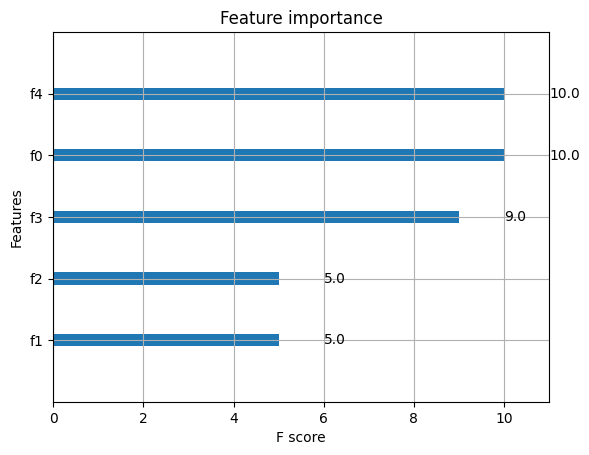

In [35]:
xgb.plot_importance(bst)